In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid19/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx


In [2]:
!pip install openpyxl

# Módulo 6 - Machine Learning: Modelos, Métricas e Validação

## Aula 01: Workflow de Machine Learning 

**Wokflow**:

* **Objetivo e Impacto no Negócio**: 
    * Prever a necessidade do uso da UTI para os pacientes do Hospital Sírio-Libanês.
    * Preparar os hospitais para previnir lotação da UTI.
     
    

* **Aquisição e Transformação dos dados**: 
    * Em nosso caso, a aquisição e o tratamento dos dados já foram realizados pela equipe do Sirio-Libanês.
    * Deve ser feita a aquisição dos dados em uma Data Warehouse ou por *web-scrapping*.
    * Escolha e engenharia de features mais importantes para a modelagem.
    * Escalonamento e normalização (caso necessário) para o uso do dataset no modelo.
    
    
    
* **Desenvolvimento do Modelo**:
    * Nas aulas de agora;
    


* **Comunicação dos Resultados:**
    * O modelo é ético? Traz resultados válidos/impactos pra empresa?
    


* **Deploy e Monitoramento**
    * Verificar o funcionamento do modelo

In [3]:
# Import nos dados

df = pd.read_excel('/kaggle/input/covid19/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx')

df.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1


In [4]:
# Função helper para retornar ao ponto do último módulo e focar nos conteúdos desse

def preenche_tabela(df):
    features_continuas_colunas = df.iloc[:, 13:-2].columns
    features_continuas = df.groupby("PATIENT_VISIT_IDENTIFIER", as_index=False)[features_continuas_colunas].fillna(method='bfill').fillna(method='ffill')
    
    features_categoricas = df.iloc[:, :13]
    saida = df.iloc[:, -2:]
    dados_finais = pd.concat([features_categoricas, features_continuas, saida], ignore_index=True, axis=1)
    dados_finais.columns = df.columns
    
    return dados_finais

In [5]:
# Dropando as linhas em que pacientes entravam direto pra UTI
df_limpo = preenche_tabela(df)
a_remover = df_limpo.query("WINDOW=='0-2' and ICU==1")['PATIENT_VISIT_IDENTIFIER'].values
df_limpo.query("PATIENT_VISIT_IDENTIFIER not in @a_remover")
df_limpo = df_limpo.dropna()

df_limpo.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,...,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000
mean,191.981771,0.468750,0.369792,0.108333,0.028125,0.097917,0.019792,0.128125,0.046875,0.213021,...,-0.758150,-0.812388,-0.910214,-0.818008,-0.759122,-0.848720,-0.771187,-0.813295,-0.910085,0.268229
std,111.312587,0.499152,0.482874,0.310882,0.165373,0.297279,0.139320,0.334316,0.211426,0.409549,...,0.433588,0.296775,0.255728,0.301726,0.389598,0.247117,0.401430,0.295619,0.256368,0.443153
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,95.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
50%,191.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
75%,288.250000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.705882,-0.690476,-0.919192,-0.710805,-0.622483,-0.764487,-0.725806,-0.698390,-0.918403,1.000000
max,384.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
# Deixando apenas a janela 0-2 e, caso o paciente for internado em algum momento depois, ICU == 1

def prepare_window(rows):
    if(np.any(rows['ICU'])):
        rows.loc[rows["WINDOW"]=="0-2", "ICU"] = 1
    return rows.loc[rows["WINDOW"] == "0-2"]

df_limpo = df_limpo.groupby("PATIENT_VISIT_IDENTIFIER").apply(prepare_window)

In [7]:
# Import das libs do sklearn 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

In [8]:
# Gerando um DummyClassifier() como baseline
np.random.seed(42)

# Pegar apenas colunas continuas
x_columns = df.describe().columns

y = df_limpo['ICU']
X = df_limpo[x_columns].drop(["ICU"], axis=1)

X_test, X_train, y_test, y_train = train_test_split(X, y, stratify = y)

dummy_model = DummyClassifier().fit(X_train, y_train)
y_pred = dummy_model.predict(X_test)

accuracy_score(y_test, y_pred)

/opt/conda/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


0.5034722222222222

In [9]:
# Gerando um LogisticRegression como baseline (melhor)

lr_model = LogisticRegression(max_iter = 2000).fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

accuracy_score(y_test, y_pred)

0.7256944444444444

Havíamos utilizado o describe para selecionar colunas contínuas. Vamos ver que colunas ficaram de fora:

In [10]:
for coluna in df.columns:
    if coluna not in x_columns:
        print(coluna)

AGE_PERCENTIL
WINDOW


A coluna `WINDOW` não é relevante para o modelo (só estamos utilizando dados de uma mesma janela). Já a `AGE_PERCENTIL` é bastante.
Vamos transforma-la em uma coluna útil ao modelo:

In [11]:
df_desafio = df_limpo.copy()

df_limpo.AGE_PERCENTIL = df_limpo.AGE_PERCENTIL.astype("category").cat.codes

In [12]:
df_limpo

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
1,5,1,1,8,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
3,15,3,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0-2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,1900,380,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
381,1905,381,1,9,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.619048,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.612627,-1.000000,0-2,0
382,1910,382,0,4,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1


Agora podemos rodar o modelo novamente:

In [13]:
x_columns = df.describe().columns

y = df_limpo['ICU']
X = df_limpo[x_columns].drop(["ICU"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

dummy_model = DummyClassifier().fit(X_train, y_train)
y_pred = dummy_model.predict(X_test)

accuracy_score(y_test, y_pred)

/opt/conda/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


0.4895833333333333

In [14]:
lr_model = LogisticRegression(max_iter = 2000).fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

accuracy_score(y_test, y_pred)

0.7291666666666666

#### Desafio 01: Transformar a coluna AGE_PERCENTIL em dados categóricos, mas utilizando outro método.

In [15]:
# Irei utilizar o pd.get_dummies para resolver o desafio:
df_desafio = pd.get_dummies(df_desafio, columns=['AGE_PERCENTIL'], prefix=['AGE_PERCENTIL'])

In [16]:
df_desafio.iloc[:, -11:].sample(5)

,,ICU,AGE_PERCENTIL_10th,AGE_PERCENTIL_20th,AGE_PERCENTIL_30th,AGE_PERCENTIL_40th,AGE_PERCENTIL_50th,AGE_PERCENTIL_60th,AGE_PERCENTIL_70th,AGE_PERCENTIL_80th,AGE_PERCENTIL_90th,AGE_PERCENTIL_Above 90th
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,
325,1625,1,0,0,0,0,0,0,1,0,0,0
332,1660,0,0,0,0,0,0,0,0,1,0,0
87,435,1,0,0,0,0,0,0,0,0,0,1
88,440,1,1,0,0,0,0,0,0,0,0,0
261,1305,1,0,0,0,0,1,0,0,0,0,0


## Aula 02 - Métricas de Avaliação

Essa aula será dividida em 2 vídeos e um extra:
* Video 01: Matriz de Confusão
* Video 02: Curva ROC e AUC
* Para saber mais: Árvore de Decisão

### Video 01 - Matriz de Confusão

#### Desafio 02: Verificar o impacto da mudança nos resultados.

In [17]:
y = df_desafio['ICU']
X = df_desafio.drop(["ICU", "WINDOW"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

lr_model = LogisticRegression(max_iter = 2000).fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

accuracy_score(y_test, y_pred)

0.71875

#### Voltando pra aula

Agora, vamos observar a diferença na acurácia de outro modelo (árvore de decisão) e aprender a decidir qual a melhor métrica de avaliação para cada tipo de modelo.

In [18]:
from sklearn.tree import DecisionTreeClassifier

tree_model = DecisionTreeClassifier().fit(X_train, y_train)

y_pred = tree_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.6666666666666666

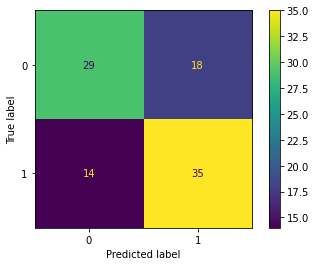

In [19]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

plot_confusion_matrix(tree_model, X_test, y_test)

A matriz de confusão é relativamente simples de entender. No **eixo X**, estão os valores que foram previstos pelo nosso modelo, enquanto no **eixo Y** estão os **dados verdadeiros**. 

Seguindo isso, podemos observar que o nosso modelo preveu 43 pacientes como `ICU == 0`, com 29 corretos (True Negatives) e 14 incorretos (False Negatives). No oposto, o modelo preveu que 53 pacientes do dataset precisariam da UTI. Desses, ele acertou 35 (True Positives) e errou 18 (False Positives). 

Para o nosso problema, é importante minimizar os **False Negatives**. Se um paciente que precisa da UTI é mandado para casa, pode ser que ocorra um agravamento da doença.

In [20]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.62      0.64        47
           1       0.66      0.71      0.69        49

    accuracy                           0.67        96
   macro avg       0.67      0.67      0.67        96
weighted avg       0.67      0.67      0.67        96



* Precision
    * De tudo que o modelo preveu como positivo (True Positives + False Positives), quantos são realmente corretos (TP / TP + FP).
    * Essa métrica deve ser utilizada quando o Falso Positivo é a principal preocupação do modelo.



* Recall
    * De tudo que o modelo preveu (True Positives + False Negative), quantos são realmente corretos (TP / TP + FN).
    * Essa métrica deve ser utilizada quando o Falso Negativo é a principal preocupação do modelo (como é o nosso caso).
    
    
* F1 - Score
    * Média harmônica entre a Precisão e Recall

#### Desafio 03 - Pesquisar sobre o F-score
Em análise estátistica de classificações binárias, o F-score é uma métrica de avaliação da acurácia do modelo. O mais comum, o **F1-score** é calculado utilizando a média harmônica da **precisão** e do **recall** do modelo. Além dele, podemos generalizar utilizando o **Fβ-score** (β que normalmente leva valores de 2 ou 0.5) em que β é escolhido de forma que o recall é considerado β vezes mais importante que a precisão.


#### Desafio 04 - Plotar a árvore de decisão

Via Kaggle 

### Video 02 - Curva ROC e AUC

A curva ROC é uma representação gráfica para visualizar a perfomance de um modelo de classificação binária de acordo com a variação do seu liminar de discrição (Rate de True Positives Vs Rate de False Positives). Além da visualização, podemos calcular também a área embaixo da curva (ROC AUC) e transformar a métrica para uma forma numérica, facilitando as comparações entre diferentes modelos.

#### Desafio 05 - Plotar a curva ROC

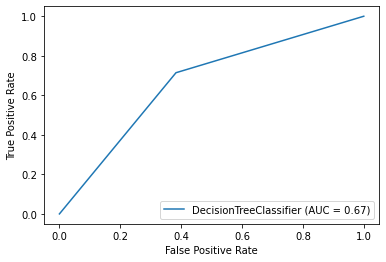

In [21]:
from sklearn.metrics import plot_roc_curve, roc_auc_score

plot_roc_curve(estimator = tree_model, X = X_test, y = y_test);

In [22]:
prob_tree = tree_model.predict_proba(X_test)
roc_auc_score(y_test, prob_tree[:,1])

0.6656534954407295

In [23]:
# Primeria função de avaliação de modelo

def roda_modelo(modelo, dados):
    X = dados.drop(["ICU", "WINDOW"], axis = 1)
    y = dados['ICU']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)
    
    modelo.fit(X_train, y_train)
    predicao = modelo.predict(X_test)
    
    auc = roc_auc_score(y_test, modelo.predict_proba(X_test)[:,1])
    print(f"AUC: {auc}")
    print("\nClassification Report ")
    print(classification_report(y_test, predicao))

In [24]:
roda_modelo(tree_model, df_limpo)

AUC: 0.5827181936604429

Classification Report 
              precision    recall  f1-score   support

           0       0.58      0.55      0.57        47
           1       0.59      0.61      0.60        49

    accuracy                           0.58        96
   macro avg       0.58      0.58      0.58        96
weighted avg       0.58      0.58      0.58        96



Cada vez que executamos a função acima, os resultados são diferentes. Isso ocorre pois tanto o algoritmo (Tree Decision) quanto o `train_test_split` tem caráter aleatório.

#### Desafio 06: Pensar e tentar diminuir o efeito da aleatoriedade nas previsões

* Setar o random_state para um valor fixo (pode acabar beneficiando/prejudicando o modelo, mas facilita a parametrização).
* Rodar o modelo diversas vezes com random_state variável e calcular a média e o desvio padrão dos resultados.

## Aula 03 - Aleatoriedade de Modelos

Uma das formas de reduzir o efeito da aleatoriedade nos modelos é criar uma iteração que rode o modelo diversas vezes, armazenando cada um dos resultados. Em seguida, calcular a média, o desvio padrão e o intervalo de confiança de 2 desvios (95%).

Dessa forma, podemos ter maior confiança que o resultado obtido pelo modelo é real e não depende de sorte (ou azar).

In [25]:
def roda_n_modelos(modelo, dados, n):
    X = dados.drop(["ICU", "WINDOW"], axis = 1)
    y = dados['ICU']
    
    auc_lista = []
    
    for i in range(n):
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

        modelo.fit(X_train, y_train)
        
        auc = roc_auc_score(y_test, modelo.predict_proba(X_test)[:,1])
        auc_lista.append(auc)
    
    auc_medio = np.mean(auc_lista)
    auc_std = np.std(auc_lista)
    print(f"AUC Médio: {auc_medio}")
    print(f"AUC STD: {auc_std}")
    print(f"LOW AUC: {auc_medio - 2*auc_std} - HIGH AUC: {auc_medio + 2*auc_std}")

In [26]:
roda_n_modelos(tree_model, df_limpo, 50)

AUC Médio: 0.6377941815023882
AUC STD: 0.040994369676553934
LOW AUC: 0.5558054421492803 - HIGH AUC: 0.7197829208554961


In [27]:
roda_n_modelos(lr_model, df_limpo, 50)

AUC Médio: 0.8022231871471993
AUC STD: 0.041316056484228855
LOW AUC: 0.7195910741787416 - HIGH AUC: 0.884855300115657


#### Desafio 07: Estudar a documentação do *scikit-learn* e testar outros modelos utilizando o método acima.

In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

models = [KNeighborsClassifier, GaussianNB, RandomForestClassifier]

for model in models:
    inst_model = model()
    print(f"{model.__name__}")
    roda_n_modelos(inst_model, df_limpo, 20)
    print("")

KNeighborsClassifier
AUC Médio: 0.6016934433347807
AUC STD: 0.03609518965471963
LOW AUC: 0.5295030640253414 - HIGH AUC: 0.67388382264422

GaussianNB
AUC Médio: 0.7652301346070343
AUC STD: 0.059575721151318796
LOW AUC: 0.6460786923043966 - HIGH AUC: 0.8843815769096719

RandomForestClassifier
AUC Médio: 0.7991315675206253
AUC STD: 0.03627769491178584
LOW AUC: 0.7265761776970536 - HIGH AUC: 0.871686957344197



## Aula 04 - Validação Cruzada

Apesar de improvável (por causa do número de vezes que cada um dos modelos foi instanciado), instanciar o modelo como fizemos acima pode fazer o modelo deixe de treinar em alguma pedaço do dataset. O Cross-Validate força o modelo a treinar em todas as partes do dataset.

Ler mais em: https://scikit-learn.org/stable/modules/cross_validation.html

Para evitar algum tipo de enviesamento no modelo, utilizamos o Cross-Validate em conjunto com algum tipo de splitter que aceite o uso de shuffle. No nosso caso, vamos utilizar o StratifiedKFold, que vai embaralhar e separar o dataset em `n_splits` partes e estratificar.

In [29]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits = 5, shuffle = True)

cross_validate(tree_model, X, y, cv = skf)

{'fit_time': array([0.02637315, 0.0282464 , 0.02617359, 0.02623463, 0.02175307]),
 'score_time': array([0.00463295, 0.00499821, 0.00511384, 0.00459814, 0.00488615]),
 'test_score': array([0.58441558, 0.67532468, 0.63636364, 0.61038961, 0.59210526])}

O *scikit-learn* também oferece suporte para realizar iterações no StratifiedKFold, como fizemos na função `roda_n_modelos`. Para isso, temos que usar o **ReapeatedStratifiedKFold**.

In [30]:
from sklearn.model_selection import RepeatedStratifiedKFold

rskf = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 10)

cross_validate(tree_model, X, y, cv = rskf)

{'fit_time': array([0.02597523, 0.02318287, 0.02792144, 0.02568674, 0.02684355,
        0.02654719, 0.02783394, 0.02791739, 0.02501845, 0.0247407 ,
        0.0272553 , 0.02415776, 0.02855849, 0.02583981, 0.02302957,
        0.02919626, 0.02547264, 0.02521849, 0.02353358, 0.02564573,
        0.02494693, 0.0257833 , 0.02288246, 0.02748084, 0.02590036,
        0.02827859, 0.02886057, 0.02645373, 0.02435017, 0.02706122,
        0.0277648 , 0.02586842, 0.02261901, 0.02656174, 0.02486658,
        0.02621198, 0.02528596, 0.02460408, 0.03163791, 0.03161812,
        0.03038001, 0.03064418, 0.02990055, 0.02617335, 0.02441096,
        0.02627063, 0.02310228, 0.02628589, 0.03730583, 0.0271666 ]),
 'score_time': array([0.00477481, 0.00470161, 0.00486708, 0.00454187, 0.00456023,
        0.00496078, 0.00511146, 0.00457931, 0.00443411, 0.00470114,
        0.00468993, 0.00464511, 0.00453186, 0.00537515, 0.00463104,
        0.00454354, 0.00449061, 0.00452709, 0.00452471, 0.00467658,
        0.00450134, 

Vamos agora implementar o Cross-Validate na função que criamos anteriormente:

In [31]:
def roda_modelo_cv(modelo, dados, n_splits, n_repeat):
    
    np.random.seed(0)
    
    dados.sample(frac=1).reset_index(drop = True)
    
    X = dados.drop(["ICU", "WINDOW"], axis = 1)
    y = dados['ICU']
    
    rskf = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = n_repeat)
    resultados = cross_validate(modelo, X, y, cv = rskf, scoring = 'roc_auc')
    
    auc_medio = np.mean(resultados['test_score'])
    auc_std = np.std(resultados['test_score'])
    
    print(f"AUC Médio: {auc_medio}")
    print(f"AUC STD: {auc_std}")
    print(f"LOW AUC: {auc_medio - 2*auc_std} - HIGH AUC: {auc_medio + 2*auc_std}")
    
roda_modelo_cv(lr_model, df_limpo, 5, 10)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


AUC Médio: 0.7885979501768975
AUC STD: 0.05482282688640678
LOW AUC: 0.6789522964040839 - HIGH AUC: 0.898243603949711


#### Desafio 08: Testar outros splitters e observar as diferenças.

In [32]:
from sklearn.model_selection import LeaveOneOut

def roda_modelo_loo(modelo, dados):
    
    np.random.seed(0)
    
    dados.sample(frac=1).reset_index(drop = True)
    
    X = dados.drop(["ICU", "WINDOW"], axis = 1)
    y = dados['ICU']
    
    loo = LeaveOneOut()
  
    resultados = cross_validate(modelo, X, y, cv = loo)
    
    auc_medio = np.mean(resultados['test_score'])
    auc_std = np.std(resultados['test_score'])
    
    print(f"AUC Médio: {auc_medio}")
    print(f"AUC STD: {auc_std}")
    print(f"LOW AUC: {auc_medio - 2*auc_std} - HIGH AUC: {auc_medio + 2*auc_std}")
    
roda_modelo_loo(tree_model, df_limpo)

AUC Médio: 0.65625
AUC STD: 0.47495887979908324
LOW AUC: -0.2936677595981665 - HIGH AUC: 1.6061677595981665


## Aula 05 - Desafios em Machine Learning

Na última aula, após a criação das funções que nos ajudam a rodar os modelos, deu pra perceber que a **árvore de decisão não obtever um resultado bom** quando comparada com o modelo usando Logistic Regression. Árvores de decisão, quando usadas sozinhas, geralmente não trazem grandes resultados. 
<br>

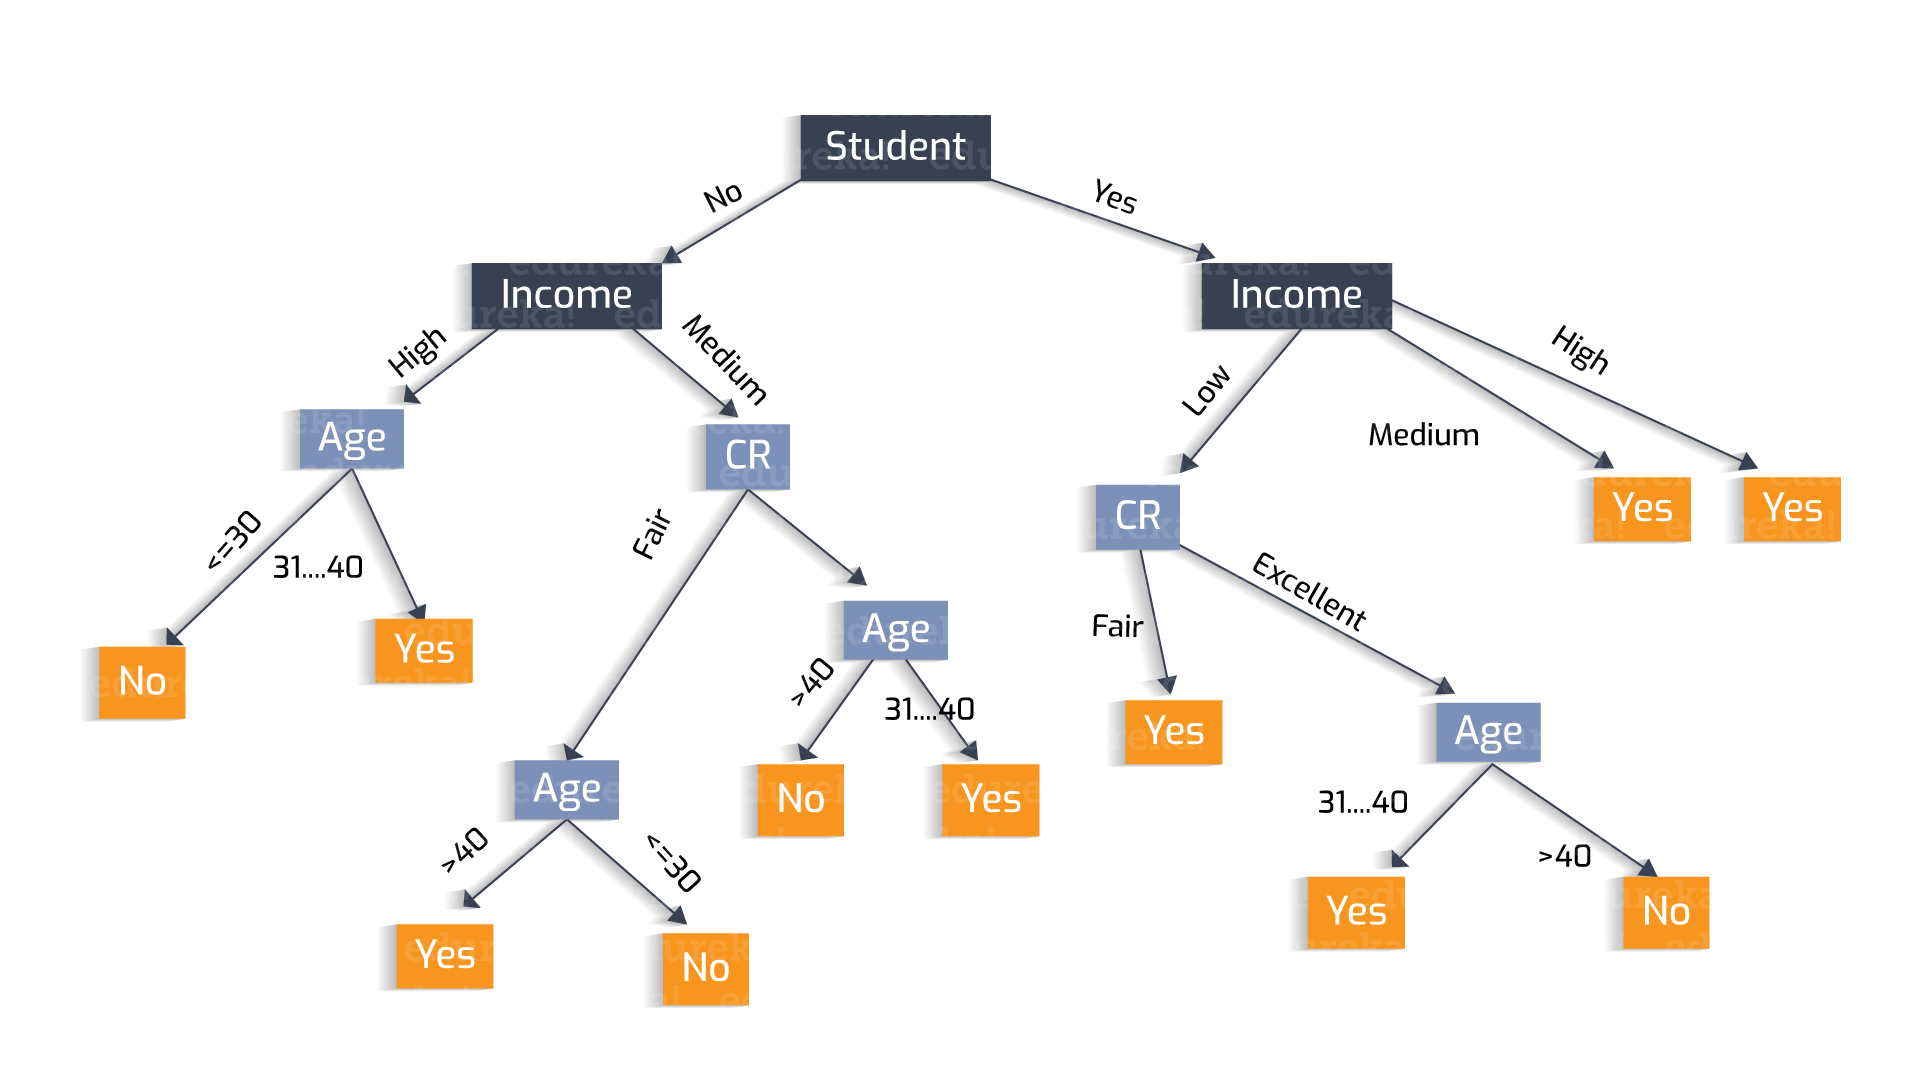

Ainda assim, podemos ajustar os **hiperparâmetros** desse algoritmo e tentar alcançar resultados ainda melhores. Um desses parâmetros é o **max_depth**, que define a profundeza máxima que essa árvore pode chegar, fazendo com que a árvore tome mais decisões para se moldar ao set de treino.

In [33]:
for i in range(5,36,10):
    print(f"Árvore com max_depth = {i}")
    tree_model_tunning = DecisionTreeClassifier(max_depth = i) 
    roda_modelo_cv(tree_model_tunning, df_limpo, 5, 10)
    print("")

Árvore com max_depth = 5
AUC Médio: 0.6765995550206079
AUC STD: 0.05865294710818543
LOW AUC: 0.559293660804237 - HIGH AUC: 0.7939054492369787

Árvore com max_depth = 15
AUC Médio: 0.6503939161833898
AUC STD: 0.05266694452085566
LOW AUC: 0.5450600271416786 - HIGH AUC: 0.7557278052251011

Árvore com max_depth = 25
AUC Médio: 0.6500430389904074
AUC STD: 0.05320883016273904
LOW AUC: 0.5436253786649293 - HIGH AUC: 0.7564606993158854

Árvore com max_depth = 35
AUC Médio: 0.6500430389904074
AUC STD: 0.05320883016273904
LOW AUC: 0.5436253786649293 - HIGH AUC: 0.7564606993158854



Para entender melhor os motivos no qual o aumento na profundeza máxima da árvore não retorna resultados melhores, vamos adiconar à função `roda_modelo_cv` os scores do modelo no set de treino (ao invés de apenas no score de teste). 

In [37]:
def roda_modelo_cv_train(modelo, dados, n_splits, n_repeat):
    
    np.random.seed(0)
    
    dados.sample(frac=1).reset_index(drop = True)
    
    X = dados.drop(["ICU", "WINDOW"], axis = 1)
    y = dados['ICU']
    
    rskf = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = n_repeat)
    resultados = cross_validate(modelo, X, y, cv = rskf, scoring = 'roc_auc', return_train_score = True)
    
    auc_medio = np.mean(resultados['test_score'])
    auc_std = np.std(resultados['test_score'])
    
    auc_medio_treino = np.mean(resultados['train_score'])
    auc_std_treino = np.std(resultados['train_score'])
    
    print("TEST SET\n")
    print(f"AUC Médio: {auc_medio}")
    print(f"AUC STD: {auc_std}")
    print(f"LOW AUC: {auc_medio - 2*auc_std} - HIGH AUC: {auc_medio + 2*auc_std}")
    
    print("\nTRAINING SET\n")
    print(f"AUC Médio: {auc_medio_treino}")
    print(f"AUC STD: {auc_std_treino}")
    print(f"LOW AUC: {auc_medio_treino - 2*auc_std_treino} - HIGH AUC: {auc_medio_treino + 2*auc_std_treino}")

In [38]:
for i in range(5,36,10):
    print(f"Árvore com max_depth = {i}")
    tree_model_tunning = DecisionTreeClassifier(max_depth = i) 
    roda_modelo_cv_train(tree_model_tunning, df_limpo, 5, 10)
    print("")

Árvore com max_depth = 5
TEST SET

AUC Médio: 0.6765995550206079
AUC STD: 0.05865294710818543
LOW AUC: 0.559293660804237 - HIGH AUC: 0.7939054492369787

TRAINING SET

AUC Médio: 0.9325161094279254
AUC STD: 0.012965703228334131
LOW AUC: 0.9065847029712572 - HIGH AUC: 0.9584475158845936

Árvore com max_depth = 15
TEST SET

AUC Médio: 0.6503939161833898
AUC STD: 0.05266694452085566
LOW AUC: 0.5450600271416786 - HIGH AUC: 0.7557278052251011

TRAINING SET

AUC Médio: 0.9999966038376634
AUC STD: 1.6637729616459098e-05
LOW AUC: 0.9999633283784305 - HIGH AUC: 1.0000298792968962

Árvore com max_depth = 25
TEST SET

AUC Médio: 0.6500430389904074
AUC STD: 0.05320883016273904
LOW AUC: 0.5436253786649293 - HIGH AUC: 0.7564606993158854

TRAINING SET

AUC Médio: 1.0
AUC STD: 0.0
LOW AUC: 1.0 - HIGH AUC: 1.0

Árvore com max_depth = 35
TEST SET

AUC Médio: 0.6500430389904074
AUC STD: 0.05320883016273904
LOW AUC: 0.5436253786649293 - HIGH AUC: 0.7564606993158854

TRAINING SET

AUC Médio: 1.0
AUC STD: 0.

Aqui podemos ver com clareza que enquanto os scores de teste se mantém ou até diminuem, os resultados do set de treino chegam em 100%. Isso acontece pois a árvore se moldou tão bem para o set de treino que a generalização para os dados de teste não acontece.
<br>

Esse problema é chamado de **overfitting**. Para resolvê-lo, temos que utilizar hiperparâmetros de regularização ou, no caso de modelos baseados em decision trees, de **poda**.

#### Desafio 09 - Criar um gráfico dos valores médios de ROC AUC de treino e de teste. 

In [40]:
def roda_modelo_cv_train(modelo, dados, n_splits, n_repeat, retorna_valor = False):
    
    np.random.seed(0)
    
    dados.sample(frac=1).reset_index(drop = True)
    
    X = dados.drop(["ICU", "WINDOW"], axis = 1)
    y = dados['ICU']
    
    rskf = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = n_repeat)
    resultados = cross_validate(modelo, X, y, cv = rskf, scoring = 'roc_auc', return_train_score = True)
    
    auc_medio = np.mean(resultados['test_score'])
    auc_std = np.std(resultados['test_score'])
    
    auc_medio_treino = np.mean(resultados['train_score'])
    auc_std_treino = np.std(resultados['train_score'])
    
    if retorna_valor:
        return auc_medio, auc_medio_treino
    
    else:
        print("TEST SET\n")
        print(f"AUC Médio: {auc_medio}")
        print(f"AUC STD: {auc_std}")
        print(f"LOW AUC: {auc_medio - 2*auc_std} - HIGH AUC: {auc_medio + 2*auc_std}")

        print("\nTRAINING SET\n")
        print(f"AUC Médio: {auc_medio_treino}")
        print(f"AUC STD: {auc_std_treino}")
        print(f"LOW AUC: {auc_medio_treino - 2*auc_std_treino} - HIGH AUC: {auc_medio_treino + 2*auc_std_treino}")

In [66]:
auc_test_list = []
auc_treino_list = []

for i in range(1,20):
    tree_model_tunning = DecisionTreeClassifier(max_depth = i) 
    auc_test, auc_treino = roda_modelo_cv_train(tree_model_tunning, df_limpo, 5, 10, retorna_valor = True)
    auc_test_list.append(auc_test)
    auc_treino_list.append(auc_treino)

In [64]:
import seaborn as sns
sns.set_palette("colorblind")

def plot_train_test_scores(train, test, parameter_range, parameter_name = 'parameter'):
    fig, ax = plt.subplots(figsize = (8,4))
    x = parameter_range

    sns.lineplot(x = x, y = test, ax = ax, label = "Test Set")
    sns.lineplot(x = x, y = train, ax = ax, label = "Train Set")

    ax.set(xlabel=parameter_name, ylabel='Score ROC AUC',
           title='')

    ax.set_xticks(x)

    plt.grid()

    ax;

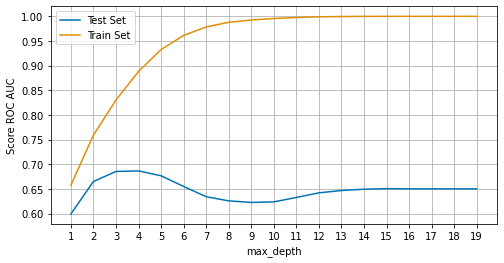

In [67]:
plot_train_test_scores(auc_treino_list, auc_test_list, np.arange(1,20), 'max_depth')

#### Desafio 10: Criar um overfitting com outra base de dados, outro modelo de ML e plotar o gráfico para análise.

#### Desafio 11: Estudar um pouco mais sobre overfit e underfit

O uso de uma segunda base de dados fica fora do escopo desse notebook. Utilizarei o Logistic Regression nessa mesma base de dados para resolver o desafio aqui mesmo.
<br>

O Logistic Regression possui muitos hiperparâmetros. No entanto, o maior destaque entre eles é o parâmetro de regularização, chamado de **C**. Quanto menor o valor de C, maior a regularização. 
<br>
A regularização é uma forma de **controlar o overfitting**, fazendo com que o modelo fique menos complexo e mais propenso a generalização. No entanto, um valor muito pequeno (ou seja, uma regularização alta demais) causa outro fenômeno, chamado de **underfitting**.

O underfitting é o oposto do overfitting. Enquanto o overfit é um fenômeno em que o modelo se molda perfeitamente ao dataset e não responde bem a novos dados, o underfit é quando o modelo fica simples demais e perde as nuances dos dados. 

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


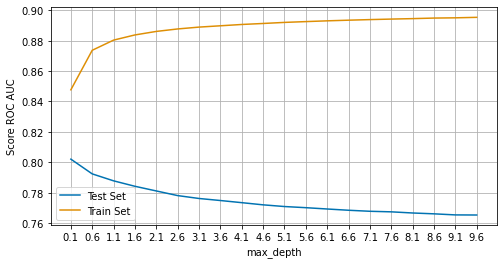

In [61]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    auc_test_list = []
    auc_treino_list = []

    for i in np.arange(0.1,10,0.5):
        lr_model_tunning = LogisticRegression(max_iter = 2000, C = i) 
        auc_test, auc_treino = roda_modelo_cv_train(lr_model_tunning, df_limpo, 5, 10, retorna_valor = True)
        auc_test_list.append(auc_test)
        auc_treino_list.append(auc_treino)
        
plot_train_test_scores(auc_treino_list, auc_test_list, np.arange(0.1,10,0.5), 'C')

Para finalizar a aula, vamos utilizar um modelo chamado de **Random Forest**. Ele é basicamente um conjunto de árvores de decisão, com cada árvore utilizando um número máximo `max_features` de features e apenas uma sample (retirada utilizando o método de `bootstrap`) do dataset. 
<br>
Por causa da forma que ele funciona, o algoritmo é muito menos propenso ao overfit. Apesar de poder acabar alcançando scores > .95 em subsets de treino, isso não torna ele fraco para o set de teste.   

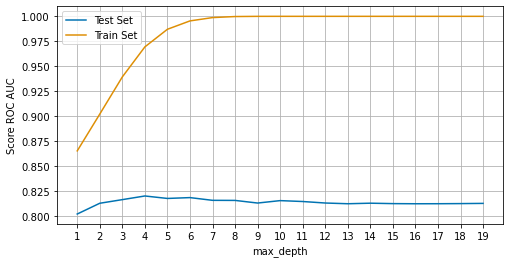

In [71]:
auc_test_list = []
auc_treino_list = []

for i in range(1,20):
    rf_model = RandomForestClassifier(max_depth = i) 
    auc_test, auc_treino = roda_modelo_cv_train(rf_model, df_limpo, 5, 10, retorna_valor = True)
    auc_test_list.append(auc_test)
    auc_treino_list.append(auc_treino)
    
plot_train_test_scores(auc_treino_list, auc_test_list, np.arange(1,20), 'max_depth')

#### Desafio 12 - Escolha um modelo de ML, estude os hiperparâmetros desse modelo e teste vários deles.

Juntei com o desafio 10. 

#### Desafio 13 - Pesquisar como salvar um modelo treinado.

Para salvar e dar load num modelo treinado anteriormente, podemos utilizar 2 libs diferentes:
* Pickle API
* Joblib API

Ambas funcionam de forma parecida, serializando e salvando objetos de Python. No entanto, a última é focada em salvar objetos que usam NumPy arrays de forma extremamente eficiente, sendo bem útil para algoritmos que guardam o dataset inteiro para fazer previsões (como é o caso do K-NN).
<br>

Em ambas as APIs, os métodos são bem similares:
* O objeto é salvo utilizando: 
    * `joblib.dump(model, "filename.sav")`
    * `pickle.dump(open("filename.sav", "wb"))`
* E é carregado para um novo projeto utilizando: 
    * `joblib.load("filename.sav")`
    * `pickle.load(open("filename.sav", "rb"))`
    
Algumas considerações devem ser tomadas ao finalizar e salvar modelos de ML, como tomar nota da versão do Python e das Libs que estão sendo utilizadas

## Aula 06 - Finalizando a validação

Um número elevado de features nem sempre significa um melhor modelo. Na maioria das vezes, na verdade, features em excesso causam danos ao modelo (seja dano em perfomance ou em custo de tempo). 
<br>

Existem diversas maneiras de selecionar e/ou cortar features e uma delas é **cortar as colunas com alta correlação**. Enquanto a alta correlação (positiva ou negativa) pode afetar a perfomance de modelos lineares, modelos baseados em árvore não são atingidos (ainda assim, são consideradas **boas práticas** realizar a remoção dessas colunas).

In [76]:
df_limpo.reset_index(drop = True, inplace = True)

df_limpo

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
1,1,1,8,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
3,3,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0-2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,380,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
380,381,1,9,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.619048,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.612627,-1.000000,0-2,0
381,382,0,4,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
382,383,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0


In [82]:
# Criando a matriz de correlação apenas dos dados contínuos
matriz_corr = df_limpo.iloc[:, 4:-2].corr().abs()

matriz_corr

,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,...,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL
DISEASE GROUPING 1,1.000000,0.232833,0.259372,0.018628,0.347914,0.199194,0.464991,0.187721,0.128779,0.013398,...,0.188455,0.042852,0.076589,0.049611,0.048554,0.052073,0.162467,0.019039,0.078430,0.049045
DISEASE GROUPING 2,0.232833,1.000000,0.072901,0.107559,0.152228,0.031235,0.140774,0.122963,0.069931,0.037642,...,0.227727,0.159572,0.219816,0.259062,0.073528,0.028948,0.224602,0.146439,0.221817,0.267425
DISEASE GROUPING 3,0.259372,0.072901,1.000000,0.300146,0.275185,0.268365,0.470774,0.067851,0.140691,0.009800,...,0.022354,0.031549,0.006847,0.012592,0.005903,0.017722,0.018194,0.026603,0.005393,0.011904
DISEASE GROUPING 4,0.018628,0.107559,0.300146,1.000000,0.127296,0.173474,0.129277,0.102198,0.061509,0.035429,...,0.022661,0.005775,0.013765,0.025052,0.043890,0.030982,0.030845,0.013118,0.014426,0.024363
DISEASE GROUPING 5,0.347914,0.152228,0.275185,0.127296,1.000000,0.129764,0.437339,0.101896,0.147387,0.046343,...,0.094562,0.021797,0.040025,0.012239,0.018934,0.057854,0.055391,0.006599,0.041944,0.012808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BLOODPRESSURE_SISTOLIC_DIFF_REL,0.052073,0.028948,0.017722,0.030982,0.057854,0.001202,0.017899,0.042838,0.036087,0.062668,...,0.315267,0.339359,0.329350,0.432987,0.776732,1.000000,0.349502,0.386949,0.323661,0.429762
HEART_RATE_DIFF_REL,0.162467,0.224602,0.018194,0.030845,0.055391,0.004998,0.110824,0.024410,0.049761,0.030320,...,0.972805,0.558114,0.686505,0.629669,0.321500,0.349502,1.000000,0.555210,0.689311,0.623838
RESPIRATORY_RATE_DIFF_REL,0.019039,0.146439,0.026603,0.013118,0.006599,0.048619,0.010122,0.006205,0.033245,0.008773,...,0.523308,0.973030,0.539410,0.517766,0.365927,0.386949,0.555210,1.000000,0.537379,0.513188
TEMPERATURE_DIFF_REL,0.078430,0.221817,0.005393,0.014426,0.041944,0.006971,0.085658,0.019229,0.006927,0.021769,...,0.645859,0.539246,0.999628,0.706897,0.289099,0.323661,0.689311,0.537379,1.000000,0.701367


In [91]:
threshold = 0.95
colunas_corr = [col for col in matriz_corr.columns if any(matriz_corr[col] > threshold)]
colunas_corr

['DISEASE GROUPING 1',
 'DISEASE GROUPING 2',
 'DISEASE GROUPING 3',
 'DISEASE GROUPING 4',
 'DISEASE GROUPING 5',
 'DISEASE GROUPING 6',
 'HTN',
 'IMMUNOCOMPROMISED',
 'OTHER',
 'ALBUMIN_MEDIAN',
 'ALBUMIN_MEAN',
 'ALBUMIN_MIN',
 'ALBUMIN_MAX',
 'BE_ARTERIAL_MEDIAN',
 'BE_ARTERIAL_MEAN',
 'BE_ARTERIAL_MIN',
 'BE_ARTERIAL_MAX',
 'BE_VENOUS_MEDIAN',
 'BE_VENOUS_MEAN',
 'BE_VENOUS_MIN',
 'BE_VENOUS_MAX',
 'BIC_ARTERIAL_MEDIAN',
 'BIC_ARTERIAL_MEAN',
 'BIC_ARTERIAL_MIN',
 'BIC_ARTERIAL_MAX',
 'BIC_VENOUS_MEDIAN',
 'BIC_VENOUS_MEAN',
 'BIC_VENOUS_MIN',
 'BIC_VENOUS_MAX',
 'BILLIRUBIN_MEDIAN',
 'BILLIRUBIN_MEAN',
 'BILLIRUBIN_MIN',
 'BILLIRUBIN_MAX',
 'BLAST_MEDIAN',
 'BLAST_MEAN',
 'BLAST_MIN',
 'BLAST_MAX',
 'CALCIUM_MEDIAN',
 'CALCIUM_MEAN',
 'CALCIUM_MIN',
 'CALCIUM_MAX',
 'CREATININ_MEDIAN',
 'CREATININ_MEAN',
 'CREATININ_MIN',
 'CREATININ_MAX',
 'FFA_MEDIAN',
 'FFA_MEAN',
 'FFA_MIN',
 'FFA_MAX',
 'GGT_MEDIAN',
 'GGT_MEAN',
 'GGT_MIN',
 'GGT_MAX',
 'GLUCOSE_MEDIAN',
 'GLUCOSE_MEAN',
 '

Utilizando uma função simples como essa retornou MUITAS features. Isso ocorreu por 2 motivos:
* Toda feature tem correlação 1 com ela mesma na diagonal principal.
* A parte abaixo da diagonal principal na matriz é um espelho da parte de cima. Nossa função excluiria ambas as colunas correlacionadas, ao invés de apenas uma.

Para resolver isso, podemos utilizar o numpy e suas funções de álgebra linear.

In [93]:
matriz_superior = matriz_corr.where(np.triu(np.ones(matriz_corr.shape), k = 1).astype(np.bool))

In [94]:
colunas_corr = [col for col in matriz_superior.columns if any(matriz_superior[col] > threshold)]
colunas_corr

['ALBUMIN_MEAN',
 'ALBUMIN_MIN',
 'ALBUMIN_MAX',
 'BE_ARTERIAL_MEAN',
 'BE_ARTERIAL_MIN',
 'BE_ARTERIAL_MAX',
 'BE_VENOUS_MEAN',
 'BE_VENOUS_MIN',
 'BE_VENOUS_MAX',
 'BIC_ARTERIAL_MEAN',
 'BIC_ARTERIAL_MIN',
 'BIC_ARTERIAL_MAX',
 'BIC_VENOUS_MEAN',
 'BIC_VENOUS_MIN',
 'BIC_VENOUS_MAX',
 'BILLIRUBIN_MEAN',
 'BILLIRUBIN_MIN',
 'BILLIRUBIN_MAX',
 'BLAST_MEAN',
 'BLAST_MIN',
 'BLAST_MAX',
 'CALCIUM_MEAN',
 'CALCIUM_MIN',
 'CALCIUM_MAX',
 'CREATININ_MEAN',
 'CREATININ_MIN',
 'CREATININ_MAX',
 'FFA_MEAN',
 'FFA_MIN',
 'FFA_MAX',
 'GGT_MEAN',
 'GGT_MIN',
 'GGT_MAX',
 'GLUCOSE_MEAN',
 'GLUCOSE_MIN',
 'GLUCOSE_MAX',
 'HEMATOCRITE_MEAN',
 'HEMATOCRITE_MIN',
 'HEMATOCRITE_MAX',
 'HEMOGLOBIN_MEDIAN',
 'HEMOGLOBIN_MEAN',
 'HEMOGLOBIN_MIN',
 'HEMOGLOBIN_MAX',
 'INR_MEAN',
 'INR_MIN',
 'INR_MAX',
 'LACTATE_MEAN',
 'LACTATE_MIN',
 'LACTATE_MAX',
 'LEUKOCYTES_MEAN',
 'LEUKOCYTES_MIN',
 'LEUKOCYTES_MAX',
 'LINFOCITOS_MEAN',
 'LINFOCITOS_MIN',
 'LINFOCITOS_MAX',
 'NEUTROPHILES_MEDIAN',
 'NEUTROPHILES_MEA

In [97]:
# Criando uma função apenas para isso
def remove_var_correlacionadas(dados, valor_corte):
    matriz_corr = dados.corr()
    matriz_superior = matriz_corr.where(np.triu(np.ones(matriz_corr.shape), k = 1).astype(np.bool))
    colunas_corr = [col for col in matriz_superior.columns if any(matriz_superior[col] > valor_corte)]
    
    return dados.drop(colunas_corr, axis = 1)

df_limpo_sem_corr = remove_var_correlacionadas(df_limpo, 0.95)

In [98]:
df_limpo_sem_corr

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,WINDOW,ICU
0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.898990,-0.247863,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
1,1,1,8,1,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000,-0.504274,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.959596,-0.435897,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,0-2,1
3,3,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.878788,-0.299145,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.939394,-0.076923,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,0-2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,380,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.898990,-0.418803,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
380,381,1,9,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.818182,-0.589744,-1.000000,-1.000000,-1.000000,-1.000000,-0.619048,-1.000000,0-2,0
381,382,0,4,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.959596,-0.299145,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
382,383,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.898990,-0.247863,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0


In [109]:
lr_model = LogisticRegression(max_iter = 2000, C= 0.1)

roda_modelo_cv(lr_model, df_limpo, 5, 10)

AUC Médio: 0.8020943210416895
AUC STD: 0.05465530976215416
LOW AUC: 0.6927837015173812 - HIGH AUC: 0.9114049405659979


In [110]:
roda_modelo_cv(lr_model, df_limpo_sem_corr, 5, 10)

AUC Médio: 0.7882897472371159
AUC STD: 0.0544458673431708
LOW AUC: 0.6793980125507743 - HIGH AUC: 0.8971814819234575


#### Desafio 14: Ler no sklearn sobre feature selection, feature importance
#### Desafio 15: Repassar pelo desafio 12, com as bases de dados alteradas.

Resolvi esses desafios utilizando o projeto final, que usa a mesma base de dados!